# **Predicción del coste de tratamiento con regresión lineal**

---

* Transformaciones
* Multicolinearidad
* Overfitting

Exploraremos un conjunto de datos dedicado al coste del tratamiento de distintos pacientes. El coste del tratamiento depende de muchos factores: diagnóstico, tipo de clínica, ciudad de residencia, edad, etc.

No disponemos de datos sobre el diagnóstico de los pacientes. Pero disponemos de otros datos que pueden ayudarnos a sacar una conclusión sobre la salud de los pacientes y practicar análisis de regresión.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_validate
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import PolynomialFeatures


# Leer Dataset

**De ser necesario, modifica la ruta de acceso (*path*) donde este ubicado el dataset "car data.csv"**

In [2]:
path = "https://raw.githubusercontent.com/GiTec-lab/Medical-Cost-Personal-Datasets/refs/heads/main/insurance.csv"

In [3]:
df = pd.read_csv(path)

Las columnas del conjunto de datos dado son las siguientes:

* **age**: edad del beneficiario principal
* **sex**: sexo del contratante del seguro, mujer, hombre
* **bmi**: índice de masa corporal, que proporciona una comprensión del cuerpo, los pesos que son relativamente altos o bajos en relación con la altura, índice objetivo de peso corporal (kg / m ^ 2) utilizando la relación entre la altura y el peso, idealmente 18.5 a 24.9.
* **children**: Número de hijos cubiertos por el seguro de enfermedad / Número de personas a cargo
* **smoker**: Fumador.
* **region**: zona de residencia del beneficiario en los EE.UU., noreste, sureste, suroeste, noroeste.
* **charges**: Gastos médicos individuales facturados por el seguro de enfermedad.

# Resumen del conjunto de datos

Utilice la celda de código siguiente para imprimir las cinco primeras filas del DataFrame `df`.

In [4]:
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Utilice las funciones `.info()` y `.describe()` para imprimir informacion de los datos y una descripcion de los datos**

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Preparacion de los datos

## Datos perdidos
Encuentre si hay datos perdidos. De ser asi, elija la estrategia correcta para lidiar con ellos.

**Hint.** `isna()`

In [7]:
df.isna().sum()


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


## Valores duplicados
Encuentre si hay entradas duplicadas. De ser asi, omita las entradas duplicadas en el dataset `df`.

**Hint.** `duplicate()` y `drop_duplicates()`

In [8]:
df.duplicated().sum()


np.int64(1)

In [9]:
df = df.drop_duplicates()


## Outliers

Un **valor atípico** (outlier) es un punto de datos que se desvía significativamente de las demás observaciones de un conjunto de datos. Es inusualmente grande o pequeño en comparación con el resto de los datos y puede indicar variabilidad en una medición, error experimental o un acontecimiento distinto.

Los valores atípicos pueden distorsionar las medidas estadísticas y el rendimiento de los modelos, por lo que su identificación y tratamiento son cruciales.

**Utiliza los gráficos de caja (*box plots*), que se basan en los percentiles, para visualizar rápidamente la distribución de los datos. Identifique si existen outliers. Enfoquese en la columna de costos (`charges`) y en el indice de masa corporal (`bmi`).**

**Hint.** `.boxplot` (`seaborn`)

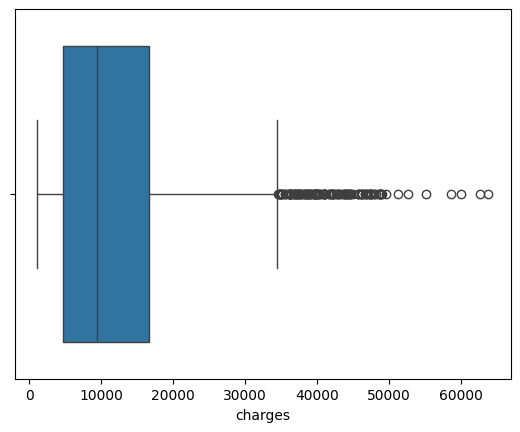

In [10]:
sns.boxplot(x=df["charges"])
plt.show()


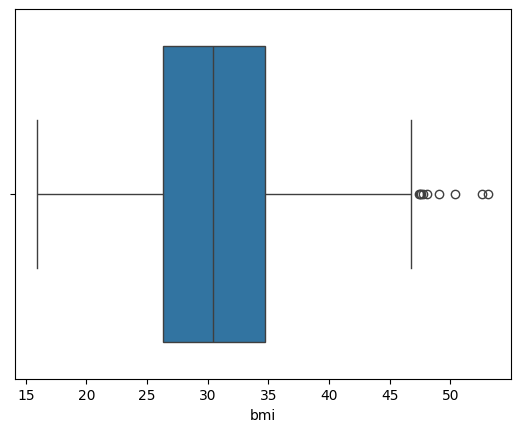

In [11]:
sns.boxplot(x=df["bmi"])
plt.show()


**En el caso de identificar outliers en la columnas de *costos* (`charges`). Utilice la distancia inter-cuartil (IQR) para encontrar la cota superior (upper-bound).**

* Muestre la cantidad a partir de la cual se considera un costo outlier

**Hint.** puede usar la funcion previamente usada `.describe()` para encontrar lo cuartiles.


In [12]:
q1 = df["charges"].quantile(0.25)
q3 = df["charges"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
upper_bound


np.float64(34524.777625)

* Use el valor de la cota superior para filtrar las entradas con valores atipicos (outliers). Guarde los outliers resultantes en una variable `dataframe` aparte e imprimelo.

In [13]:
outliers_df = df[df["charges"] > upper_bound]
outliers_df


,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


**Analice los outliers para averiguar que caracteristicas tienen. Existe algun grupo predominante en cuanto a los que tienen mayores costos:**

* Edad, Sexo, bmi, fumadores, numero de hijos?.

**Liste sus descubrimientos.**

Los outliers identificados corresponden principalmente a pacientes fumadores con un IMC elevado y costos médicos por encima de 34 500.
La mayoría pertenecen a la región southeast, lo que podría indicar una mayor incidencia de tratamientos costosos o condiciones médicas más graves en ese grupo.
En general, los valores atípicos se asocian con el hábito de fumar y un IMC superior a la media.

# Exploratory Data Analysis.

Para conocer mas sobre la composicion y proporciones en nuestros datos.

Dependiendo de los tipos de datos: categoricos y numericos.

**Conteste las siguientes preguntas respecto al dataset**


## Datos categoricos

Un histograma nos sirve para revelar el centro de los datos. De la misma manera, un **gráfico de recuento** puede considerarse como un histograma de una variable categórica, en lugar de cuantitativa.

### **¿Qué región cuesta más?**

**Investigue si hay alguna region que cueste particularmente más. Utilice grafica de barras para representar sus descubrimientos.**

**HINT:** `sns.barplot`

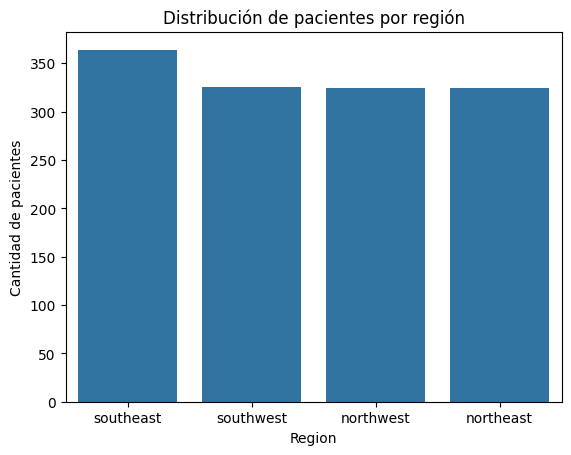

In [14]:
sns.barplot(x=df["region"].value_counts().index, y=df["region"].value_counts().values)
plt.xlabel("Region")
plt.ylabel("Cantidad de pacientes")
plt.title("Distribución de pacientes por región")
plt.show()


### **¿La vejez cuesta más?**


**Pongamos atencion a la distribucion de los pacientes. Primero, veamos la distribucion de `age`.**

**HINT:** `sns.histplot` se recomienda `kde=True`

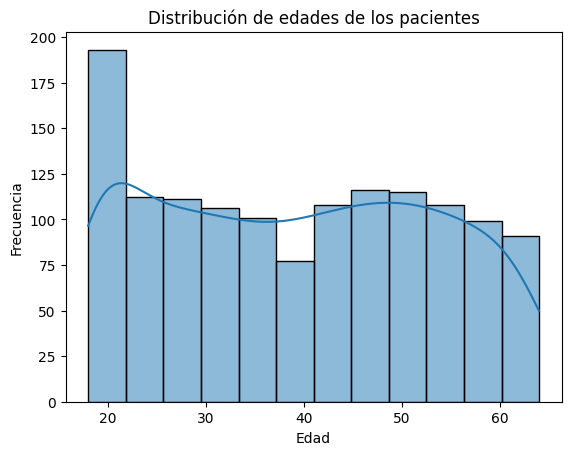

In [15]:
sns.histplot(df["age"], kde=True)
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.title("Distribución de edades de los pacientes")
plt.show()


**Investigue si la edad (`Age`) de los pacientes tiene algun impacto en los costos (`charges`). Se recomiendo el uso de grafico de dispersion (scatter plot) para mostrar sus hallazgos. Sin embargo, puede elegir otro que muestre con más claridad los resultados.**

Puede elegir el color de los puntos utilizando alguna otra variable (variable `c` en `scatter()`). Esto para agregar mayor informacion al grafico e identificar grupos diferentes.

**HINT:** `plt.scatter`

Se recomienda `cmap = 'summer'`

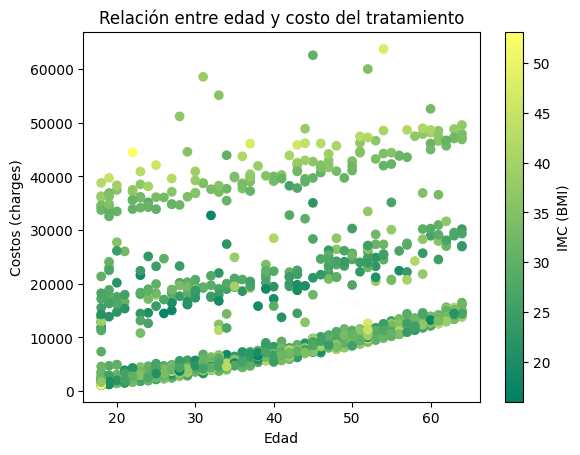

In [16]:
plt.scatter(df["age"], df["charges"], c=df["bmi"], cmap="summer")
plt.xlabel("Edad")
plt.ylabel("Costos (charges)")
plt.title("Relación entre edad y costo del tratamiento")
plt.colorbar(label="IMC (BMI)")
plt.show()


### **¿Qué genero cuesta más?**

**Investigue si el sexo (`sex`) de los pacientes tiene algun impacto en los costos. Puede usar histogramas para mostrar sus hallazgos.**

Se recomienda que se muestre la comparativa en una sola grafica.

**HINT:** `sns.histplot`

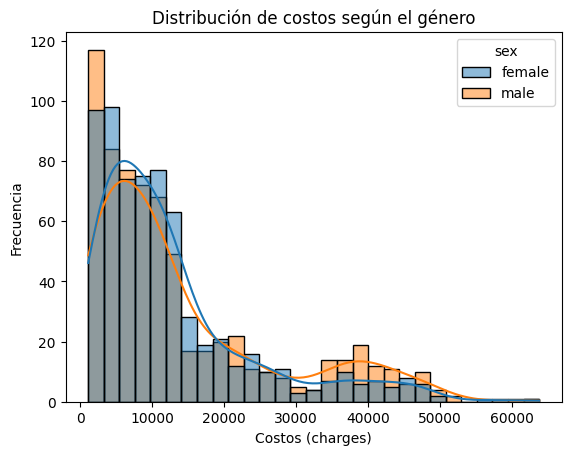

In [17]:
sns.histplot(data=df, x="charges", hue="sex", kde=True)
plt.xlabel("Costos (charges)")
plt.ylabel("Frecuencia")
plt.title("Distribución de costos según el género")
plt.show()


Considera la proporcion de hombres y mujeres en el dataset. **¿Cuáles son sus conclusiones?**

Los costos médicos tienden a aumentar con la edad y el IMC, especialmente en pacientes mayores y con sobrepeso.
En cuanto al género, no hay una diferencia marcada en los costos promedio entre hombres y mujeres, aunque las mujeres presentan una ligera mayor variabilidad.
La región con más registros es southeast, lo que sugiere que la mayor parte de los pacientes provienen de esa zona.


### **¿Fumar cuesta más?**

**Investigue si los pacientes que son fumadores (`smoker`) sufren algun impacto en los costos. Puede usar histogramas para mostrar sus hallazgos.**

Se recomienda que se muestre la comparativa en una sola grafica.

**HINT:** `sns.histplot` se recomienda `kde=True`


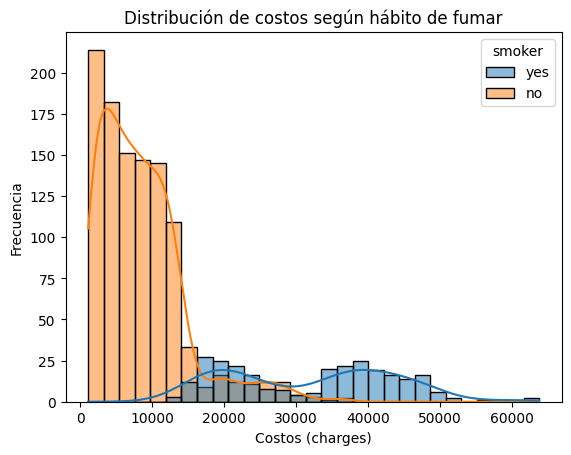

In [18]:
sns.histplot(data=df, x="charges", hue="smoker", kde=True)
plt.xlabel("Costos (charges)")
plt.ylabel("Frecuencia")
plt.title("Distribución de costos según hábito de fumar")
plt.show()




---


**¿Cuáles son sus conclusiones en general?**

Los fumadores presentan costos médicos considerablemente más altos que los no fumadores, con una distribución mucho más extendida hacia valores elevados. Esto sugiere que fumar tiene un fuerte impacto en los gastos del tratamiento médico.


# Datos numericos

## Costos

Veamos la distribución de los gastos (`charges`). Esto nos ayudará a saber cuánto gastan de media los pacientes en el tratamiento.

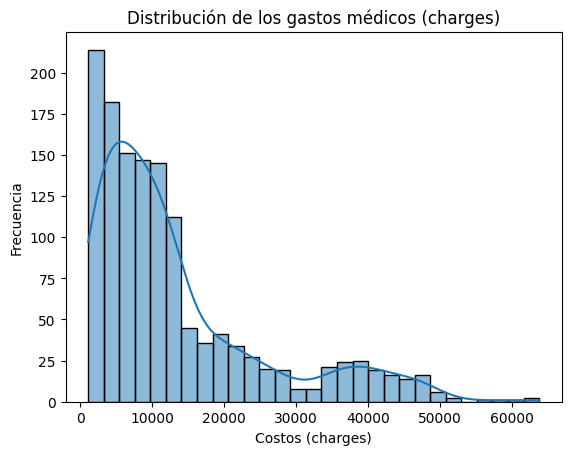

In [19]:
sns.histplot(df["charges"], kde=True)
plt.xlabel("Costos (charges)")
plt.ylabel("Frecuencia")
plt.title("Distribución de los gastos médicos (charges)")
plt.show()


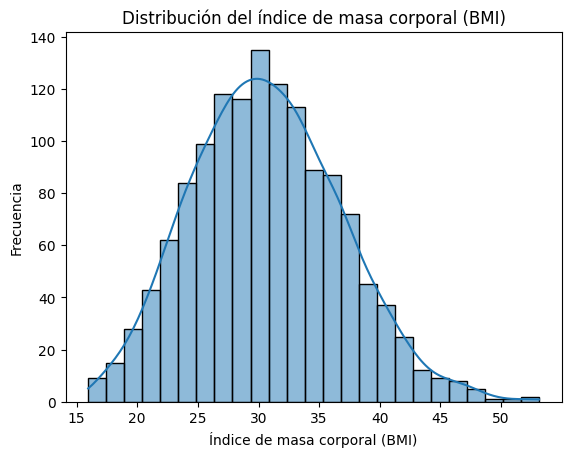

In [20]:
sns.histplot(df["bmi"], kde=True)
plt.xlabel("Índice de masa corporal (BMI)")
plt.ylabel("Frecuencia")
plt.title("Distribución del índice de masa corporal (BMI)")
plt.show()


## BMI

Prestemos atención a `bmi`.

**Explore la distribucion. Utlice un grafico de su preferencia para mostrar la distribucion de la variable `bmi`.**

**HINT:** `sns.histplot` se recomienda `kde=True`

In [ ]:
# TODO: Your code here!

**Analiza la distribucion/composicion de los datos (skewness)**

Hay algo increíblemente hermoso en esta distribución, ¿verdad?

**¿Que significa el valor mas predominante de `bmi` del dataset?**

La distribución del IMC presenta una ligera asimetría positiva, con la mayoría de los valores concentrados entre 25 y 35.
Esto indica que la mayoría de los pacientes tienen sobrepeso, lo cual podría estar relacionado con el aumento en los costos médicos.



# Codificación de variables categóricas.

Los datos categóricos deben convertirse a menudo a formato numérico. Las técnicas incluyen la **codificación one-hot** y la **codificación de etiquetas** utilizando la biblioteca scikit-learn de python.

**HINT:** `pd.get_dummies()`, `dtype`, `drop_first`

Aplique la codificación que usted considere adecuada (*ordinal* o *one-hot*), evita la posible colinealidad dejando una categoria como referencia.

**Modifique el dataframe original `df` aplicando la codificacion a las columnas: `sex`, `smoker`, `region`**

In [21]:
df = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)
df.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [22]:
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


* Comprueba la colinearidad de las variables

In [23]:
df.corr()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109344,0.041536,0.298308,-0.019814,-0.025587,0.001495,-0.012311,0.009415
bmi,0.109344,1.000000,0.012755,0.198401,0.046397,0.003746,-0.136138,0.270057,-0.006211
children,0.041536,0.012755,1.000000,0.067389,0.017848,0.007331,0.026044,-0.023492,0.021538
charges,0.298308,0.198401,0.067389,1.000000,0.058044,0.787234,-0.038695,0.073578,-0.043637
sex_male,-0.019814,0.046397,0.017848,0.058044,1.000000,0.076596,-0.012482,0.017578,-0.003767
smoker_yes,-0.025587,0.003746,0.007331,0.787234,0.076596,1.000000,-0.036321,0.068282,-0.037168
region_northwest,0.001495,-0.136138,0.026044,-0.038695,-0.012482,-0.036321,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270057,-0.023492,0.073578,0.017578,0.068282,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006211,0.021538,-0.043637,-0.003767,-0.037168,-0.320493,-0.346614,1.000000




---


# Implementacion perezosa del modelo de regresión lineal.

El primer paso para entrenar un modelos es determinar las características y la variables objetivo. Esto es, dividir los datos en las variables independientes (**`X`**) , caracteristicas que se usaran para la prediccion, y la variable dependiente (**`Y`**), la caracteristica que queremos predecir.

**Cree dos variables (`X` y `Y`), en la variable `X` guarde una version del `dataframe` omitiendo la variable a predecir, `charges`.**

**En la variable `Y` guarde una version del `dataframe` conteniendo solo la variable a predecir, `charges`.**

In [29]:
X = df.drop("charges", axis=1)
y = df["charges"]


A continuacion se divide el conjunto de datos en **conjuntos de entrenamiento** y **prueba**.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

**Dado que hemos realizado operaciones de filtrado que han desorganizado los indices (`index`) del `dataframe`. Se Utiliza `.reset_index()` para solucionarlo.**

In [32]:
X_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)

In [33]:
X_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

Verifique que, por ejemplo, `X_train` se muestre correctamente

In [34]:
X_train

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,43,20.045,2,False,True,False,False,False
1,18,34.430,0,True,False,False,True,False
2,23,36.670,2,False,True,False,False,False
3,54,27.645,1,False,False,True,False,False
4,58,27.170,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...
1064,45,25.175,2,False,False,False,False,False
1065,36,31.500,0,True,False,False,False,True
1066,29,37.290,2,True,False,False,True,False
1067,19,35.530,0,True,False,True,False,False


* El siguiente paso es el escalado de características con el escalador estándar (**z-score**):

**Formula:**
$$
X_{scaled} = \frac{X - \bar{X}}{S}
$$
*donde $\bar{X}$ es la media y $S$ es la desviacion estandar.*

<br>

Aplique `StandardScaler.set_output(transform="pandas")` (`sklearn`) en las variables numéricas (`age`, `bmi`, `children`)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


In [36]:
scaler = StandardScaler()
X_train[["age", "bmi", "children"]] = scaler.fit_transform(X_train[["age", "bmi", "children"]])
X_test[["age", "bmi", "children"]] = scaler.transform(X_test[["age", "bmi", "children"]])


**A continuacion, realiza una implementacion perezosa del modelo de regresion lineal que nos servira como base**

**HINT:** `sm.OLS()` (`statsmodels`)

**HINT 2:** Recuerde que, al utilizar el modelo de `statsmodels`, es necesario agregar el valor constante `sm.add_constant()`

Recuerde mostrar el resumen del modelo (`.summary()`) para poder visualizar la informacion estadistica del modelo.

In [39]:
X_train_const = sm.add_constant(X_train)
X_train_const = X_train_const.astype(float) # Convert boolean columns to integers
model = sm.OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     395.1
Date:                Sat, 25 Oct 2025   Prob (F-statistic):          9.52e-312
Time:                        04:11:00   Log-Likelihood:                -10808.
No. Observations:                1069   AIC:                         2.163e+04
Df Residuals:                    1060   BIC:                         2.168e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             9022.4557    426.486     21.155      0.000    8185.602    9859.309
age               3444.1178    184.171     18.701      0.000    3082.736    3805.500
bmi               1892.5935    191.880      9.863      0.000    1516.086    2269.101
children           591.2719    183.117      3.229      0.001     231.958     950.586
sex_male          -201.7254    366.435     -0.551      0.582    -920.745     517.294
smoker_yes        2.379e+04    457.171     52.036      0.000    2.29e+04    2.47e+04
region_northwest  -448.3506    525.734     -0.853      0.394   -1479.949     583.248
region_southeast  -993.1001    530.581     -1.872      0.062   -2034.209      48.009
region_southwest -1087.7975    524.039     -2.076      0.038   -2116.069     -59.526
==============================================================================
Omnibus:                      269.407   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              734.940
Skew:                           1.287   Prob(JB):                    2.57e-160
Kurtosis:                       6.142   Cond. No.                         5.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analisis de residuos

**Calcula los residuos studentizados y graficalos en un scatter plot**

$$
𝒓_𝒊= \frac{𝒆_𝒊}{𝝈^𝟐 \sqrt{(𝟏−𝒉_{𝒊𝒊})}}
$$

**HINT:** `.get_influence()`

* Grafique un scatterplot con los residuos studentizados del conjunto de datos train. **HINT:** `.fittedvalues`
* Muestre las lineas verticales de los umbrales.
* Muestre aquellas muestras en particular que esten mas alla de los umbrales definidos.

In [40]:
influence = model.get_influence()
residuals = influence.resid_studentized_internal
fitted = model.fittedvalues


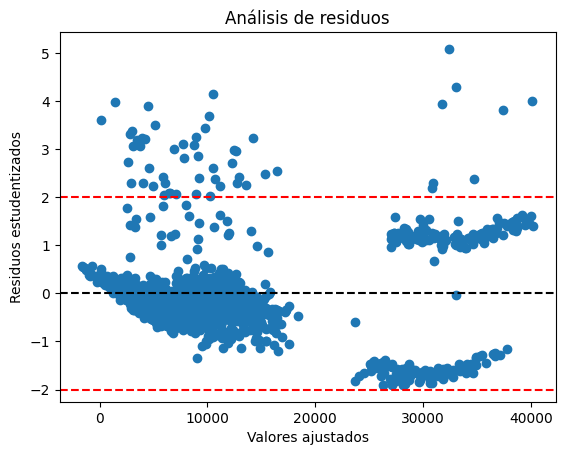

In [41]:
plt.scatter(fitted, residuals)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=2, color='red', linestyle='--')
plt.axhline(y=-2, color='red', linestyle='--')
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos estudentizados")
plt.title("Análisis de residuos")
plt.show()


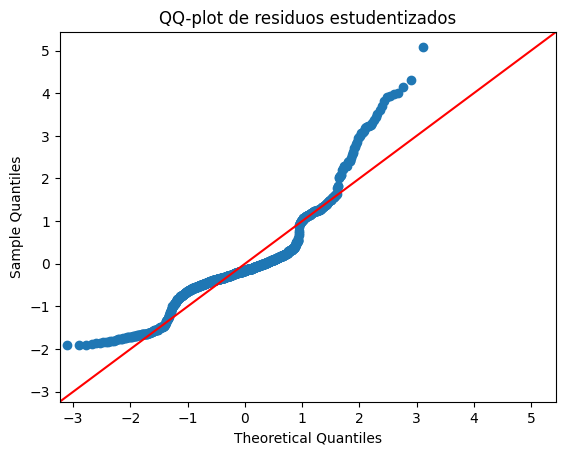

In [42]:
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ-plot de residuos estudentizados")
plt.show()


* **Realiza un grafico QQ-plot para estos residuos studentizados**

**HINT:** `sm.qqplot`

In [43]:
X_test_const = sm.add_constant(X_test)
y_pred_train = model.predict(X_train_const)
y_pred_test = model.predict(X_test_const)


Recordemos que esta es una implementación perezosa.

* Evaluación del modelo de regresión lineal.

Realiza una prediccion con el conjunto de **datos de test** y otro con los **datos de train**, y Utiliza las métricas de evaluación para medir el rendimiento de un modelo. Utiliza el **MSE** o **RMSE** y **R cuadrado** para cada conjunto de datos y compara.

* **MSE** penaliza errores grandes.
$$
MSE = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2
$$

* **RMSE** penaliza errores grandes.
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2}
$$

**Hint.** `mean_squared_error`, `r2_score`.

**Note.** Para la prediccion en los datos de test y train tendras que agregar la constante, igual a como lo entrenaste.

In [44]:
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("MSE Train:", mse_train)
print("MSE Test:", mse_test)
print("RMSE Train:", rmse_train)
print("RMSE Test:", rmse_test)
print("R2 Train:", r2_train)
print("R2 Test:", r2_test)


MSE Train: 35391932.946231805
MSE Test: 41546216.66086838
RMSE Train: 5949.111946016128
RMSE Test: 6445.635473781338
R2 Train: 0.748860461829179
R2 Test: 0.7530385567240128


In [46]:
print('R2 score on testing dataset: ', r2_score(y_test, y_pred_test))
print('R2 score on training dataset: ', r2_score(y_train, y_pred_train))

print('\nMSE on testing dataset: ', mean_squared_error(y_test, y_pred_test))
print('MSE on training dataset: ', mean_squared_error(y_train, y_pred_train))

R2 score on testing dataset:  0.7530385567240128
R2 score on training dataset:  0.748860461829179

MSE on testing dataset:  41546216.66086838
MSE on training dataset:  35391932.946231805


Sobre estos resultados, ¿considera que el modelo se encuentra con overfittin, underfitting o balanceado? Explique su respuesta.

El modelo se encuentra balanceado.
Los valores de R² son similares en los conjuntos de entrenamiento (0.7488) y prueba (0.7530), lo que indica una buena capacidad de generalización.
La diferencia entre los errores (RMSE y MSE) es pequeña, por lo que no hay señales de overfitting ni underfitting.
En conclusión, el modelo logra un ajuste adecuado para los datos y predice los costos médicos con un nivel aceptable de precisión.

---
---
---
# Segundo Intento (transformacion de datos)

Aquí no hablamos de "cambiar escalas", sino de alterar la forma de las variables para que el modelo cumpla mejor los supuestos de OLS y las relaciones entre variables se describan de manera más fiel.

<br>

La regresión OLS no requiere que las **variables independientes** tengan una distribución normal. Lo que importa es que no sean colineales y que la relación con la variable dependiente sea lineal. Pero si una variable independiente está muy sesgada, al aplicar una transformación, se puede alinear mejor con la variable dependiente, dando residuos más pequeños y se cumplan mejor los supuestos (linealidad y homocedasticidad).

<br>

La **variable dependiente** `Y` tampoco necesita ser normal para estimar los coeficientes con OLS. Lo que sí requiere normalidad (aproximada) son los residuos. Aunque trasformar `Y` se hace para que los residuos cumplan mejor normalidad y homocedasticidad.

* Escoge las variables numericas (independientes y/o dependiente) que consideres y aplica la transformacion `boxcox`. Utiliza una variable temporal llamada `transformed_data` para probar con el modelo.

* Experimenta y ve los resultados.

* Al terminar, recuerda las transformaciones adecuadas, nos serviran para el siguiente paso.

In [ ]:
transformed_data = df.copy()

In [ ]:
# TODO: Your code here!

In [ ]:
# TODO: Your code here!

* Una vez mas se divide el conjunto de datos transformados en **conjuntos de entrenamiento** y **prueba** y se **reorganizan los indices** (`index`) del `dataframe`.

In [ ]:
X = transformed_data.drop('charges',axis= 1)
Y = transformed_data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

X_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)

X_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

* Realiza otra implementacion del modelo de regresion lineal

Muestre el resumen del modelo (`.summary()`) para poder visualizar la informacion estadistica del modelo.

In [ ]:
# TODO: Your code here!

* Evaluación del modelo de regresión lineal. Compara el desempeño entre el conjunto de datos de `test` y `train`.

**Hint.** `mean_squared_error`, `r2_score`.

In [ ]:
# TODO: Your code here!

In [ ]:
print('R2 score on testing dataset: ', r2_score(y_test, y_test_pred))
print('R2 score on training dataset: ', r2_score(y_train, y_train_pred))

print('\nMSE on testing dataset: ', mean_squared_error(y_test, y_test_pred))
print('MSE on training dataset: ', mean_squared_error(y_train, y_train_pred))

**Que efecto tuvo la transformacion de las variables en el desempeño del modelo?**

```
# TODO: Your answer here!
```

---
---
---

# Tercer Intento (Polynomial Features)

A continuacion, necesitamos experimentar añadiendo combinaciones polinómicas de las características y miremos el resultado.

* Sustituya o transforme las variables en nuestro dataframe original `df` que resultaron exitosas. Puede utilizar la variable `transformed_data` utilizada previamente.

In [ ]:
# TODO: Your code here!

* Una vez mas se divide el conjunto de datos transformados en **conjuntos de entrenamiento** y **prueba** y se **reorganizan los indices** (`index`) del `dataframe`.

In [ ]:
X = df.drop('charges',axis= 1)
Y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

X_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)

X_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

Recordemos que agregar caracteristicas polinomicas o de interaccion agrega `Multicolineridad estructural` al modelo.


**Centrar las variables numericas es una forma de reducir la multicolinealidad estructural.**

Existen otros métodos de estandarización, pero la ventaja de simplemente restar la media es que la interpretación de los coeficientes sigue siendo la misma.

* Centra las variables numericas independientes, puedes utilizar la funcion `StandardScaler`.

**Hint.** `with_mean=`, `with_std=`, `.set_output()`.


In [ ]:
# TODO: Your code here!

* Encuentra un grado de combinacion polinomica de caracteristicas que pudiera llevar a nuestro modelo a un desempeño superior. Transforme el conjunto de `test` y `train`. Si gusta puede crear una nueva variable para guardar los datos con las nuevas caracteristicas.

**Hint.** `PolynomialFeatures(degree= , include_bias=)`, `.set_output()`

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# TODO: Your code here!

* Implemente el modelo de regresion lineal utilizando los datos de entrenamiento con caracteristicas aumentadas.

Muestre el resumen del modelo (`.summary()`) para poder visualizar la informacion estadistica del modelo.

In [ ]:
# TODO: Your code here!

* Grafique un scatterplot con los residuos studentizados del conjunto de datos train. **HINT:** `.fittedvalues` y muestre las lineas verticales de los umbrales.

In [ ]:
# TODO: Your code here!

**Observando el grafico de los residuos, ¿Que comportamientos se pueden observar en los datos?¿A se lo atribuyes?**

```
TODO: Your comment here!
```

* Realiza un grafico QQ-plot para estos residuos studentizados

**HINT:** `sm.qqplot`

In [ ]:
# TODO: Your code here!

* Evaluación del modelo de regresión lineal. Compara el desempeño entre el conjunto de datos de `test` y `train`.

**Hint.** `mean_squared_error`, `r2_score`.

In [ ]:
# TODO: Your code here!

**Al realizar las modificaciones, ¿Cuales son sus observaciones en el desempeño del modelo, Mejoro?¿A que variable se lo atribuyes?**

```
TODO: Your comment here!
```

**¿Qué sucede si el grado de las caracterisitcas polinomicas es muy grande?¿Como afecta al modelo?**

```
TODO: Your comment here!
```
